# NLP for the Evalutation of Relgious Texts - Deep Learning

This notebook includes post-data cleaning code that analyzes religious text. Note that our analysis includes in Gospel of Buddha, but our corresponding paper omits this religious text because of the incompletion in the book.

## Set-up

In [1]:
import numpy as np
import pandas as pd
import torch
import pprint
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline

In [2]:
# read in CSV files
bible = pd.read_csv("bible1.csv")
buddha = pd.read_csv("buddha1.csv").dropna(axis=0, subset=['translation-en-sujato']).reset_index()
mormon = pd.read_csv("mormon1.csv")
quran = pd.read_csv("quran.csv")

In [11]:
quran_grouped

,JuzNo,SurahNo,EnglishTranslation
0,1,1,"In the name of Allah, Most Gracious, Most Merc..."
1,1,2,A. L. M. This is the Book; in it is guidance s...
2,2,2,"The fools among the people will say: ""What hat..."
3,3,2,"Those messengers We endowed with gifts, some a..."
4,3,3,"A. L. M. Allah! There is no god but He,-the Li..."
...,...,...,...
130,30,110,"When comes the Help of Allah, and Victory, And..."
131,30,111,Perish the hands of the Father of Flame! Peris...
132,30,112,"Say: He is Allah, the One and Only; Allah, the..."
133,30,113,Say: I seek refuge with the Lord of the Dawn F...


## Semantic Search

### Set-up

In [3]:
bible_text = bible['Text']
buddha_text = buddha['translation-en-sujato']
mormon_text = mormon['scripture_text']
quran_text = quran['EnglishTranslation']

In [4]:
# Use a bi-directional autoencoder to create the corpus embeddings
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [5]:
# # Create Bible embeddings and save them locally
# bible_embeddings = model.encode(bible_text, convert_to_tensor=True, show_progress_bar=True, normalize_embeddings=True)
# torch.save(bible_embeddings, "bible.pt")

# # Same for buddha
# buddha_embeddings = model.encode(buddha_text, convert_to_tensor=True, show_progress_bar=True, normalize_embeddings=True)
# torch.save(buddha_embeddings, "buddha.pt")

# # Same for mormon
# mormon_embeddings = model.encode(mormon_text, convert_to_tensor=True, show_progress_bar=True, normalize_embeddings=True)
# torch.save(mormon_embeddings, "mormon.pt")

# # Same for quran
# quran_embeddings = model.encode(quran_text, convert_to_tensor=True, show_progress_bar=True, normalize_embeddings=True)
# torch.save(quran_embeddings, "quran.pt")

In [7]:
# Load embeddings
bible_embeddings = torch.load("bible.pt", map_location=torch.device('cpu'))
buddha_embeddings = torch.load("buddha.pt", map_location=torch.device('cpu'))
mormon_embeddings = torch.load("mormon.pt", map_location=torch.device('cpu'))
quran_embeddings = torch.load("quran.pt", map_location=torch.device('cpu'))

### Search Implementation

In [9]:
def search_papers(concept, top_k):
    # Embed the query
    query_embedding = model.encode(concept, convert_to_tensor=True)
    
    # Get the search hits
    bible_search_hits = util.semantic_search(query_embedding, bible_embeddings, top_k=top_k)[0]
    buddha_search_hits = util.semantic_search(query_embedding, buddha_embeddings, top_k=top_k)[0]
    mormon_search_hits = util.semantic_search(query_embedding, mormon_embeddings, top_k=top_k)[0]
    quran_search_hits = util.semantic_search(query_embedding, quran_embeddings, top_k=top_k)[0]
    
    # Get the row indexes of the top k hits (in case we want to use these later)
    bible_hit_indexes = [x['corpus_id'] for x in bible_search_hits]
    buddha_hit_indexes = [x['corpus_id'] for x in buddha_search_hits]
    mormon_hit_indexes = [x['corpus_id'] for x in mormon_search_hits]
    quran_hit_indexes = [x['corpus_id'] for x in quran_search_hits]
    
    #Bible search results
    print("Search:", concept)
    print("Most similar verses in the Bible: ")
    pprint.pprint([{bible.iloc[x]["Book Name"] + 
             " " + 
             str(bible.iloc[x]["Chapter"]) + 
             ":" +
             str(bible.iloc[x]["Verse"]) :bible.iloc[x]["Text"]} for x in bible_hit_indexes])
      
    #Buddha search results
    print("\n\n Most similar verses in Buddha")
    pprint.pprint([{buddha.iloc[x]['segment_id']: buddha.iloc[x]['translation-en-sujato']} for x in buddha_hit_indexes])
    
    # Mormon search results
    print("\n\n Most similar verses in Mormon")
    pprint.pprint([{mormon.iloc[x]["volume_title"] + "- "+
                mormon.iloc[x]["book_title"] + 
             " " + 
             str(mormon.iloc[x]["chapter_number"]) + 
             ":" +
             str(mormon.iloc[x]["verse_number"]) : mormon.iloc[x]['scripture_text']} for x in mormon_hit_indexes])
    
    #Quran search results
    print("\n\n Most similar verses in Quran")
    pprint.pprint([{str(quran.iloc[x]['SurahNo']) + 
             ":" +
             str(quran.iloc[x]['AyahNo']) + " Quran" : quran.iloc[x]['EnglishTranslation']} for x in quran_hit_indexes])
    
    return None

In [10]:
search_papers('Love and peace in the world', 5) # search for a concept

Search: Love and peace in the world
Most similar verses in the Bible: 
[{'Psalms 85:10': 'Mercy and truth are met together; righteousness and peace '
                  'have kissed [each other].'},
 {'Ephesians 6:23': 'Peace [be] to the brethren, and love with faith, from God '
                    'the Father and the Lord Jesus Christ.'},
 {'Romans 14:19': 'Let us therefore follow after the things which make for '
                  'peace, and things wherewith one may edify another.'},
 {'Luke 2:14': 'Glory to God in the highest, and on earth peace, good will '
               'toward men.'},
 {'2 Thessalonians 3:16': ' Now the Lord of peace himself give you peace '
                          'always by all means. The Lord [be] with you all.'}]


 Most similar verses in Buddha
[{'dn19:44.21': 'or happiness in lives to come.” '},
 {'dn19:14.9': 'With clear and peaceful minds, '},
 {'dn18:14.5': 'With clear and peaceful minds, '},
 {'dn19:59.1': 'And the Great Steward meditated spreading a

!!! Need a better output format

## Extractive Summarization

Methods and brief descriptions are derived from: https://machinelearninggeek.com/text-summarization-using-python/

In [5]:
bible_grouped = bible.groupby(['Book Name', 'Chapter'])['Text'].apply(' '.join).reset_index()
mormon_grouped = mormon.groupby(['volume_title', 'book_title', 'chapter_number'])['scripture_text'].apply(' '.join).reset_index()
quran_grouped = quran.groupby(['JuzNo', 'SurahNo'])['EnglishTranslation'].apply(' '.join).reset_index()
buddha_grouped = buddha.groupby(['level_1', 'level_2'])['translation-en-sujato'].apply(' '.join).reset_index()

In [12]:
test = mormon_grouped[mormon_grouped['book_title'] == 'Mark']
text = test.iloc[10]['scripture_text']

text # display text paragraph that summarization works on

'And when they came nigh to Jerusalem, unto Bethphage and Bethany, at the mount of Olives, he sendeth forth two of his disciples, And saith unto them, Go your way into the village over against you: and as soon as ye be entered into it, ye shall find a colt tied, whereon never man sat; loose him, and bring him. And if any man say unto you, Why do ye this? say ye that the Lord hath need of him; and straightway he will send him hither. And they went their way, and found the colt tied by the door without in a place where two ways met; and they loose him. And certain of them that stood there said unto them, What do ye, loosing the colt? And they said unto them even as Jesus had commanded: and they let them go. And they brought the colt to Jesus, and cast their garments on him; and he sat upon him. And many spread their garments in the way: and others cut down branches off the trees, and strawed them in the way. And they that went before, and they that followed, cried, saying, Hosanna; Bless

### Summarization using `sumy`

In [13]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

#### `LexRank`

A graph-based method of summarization, `LexRank` is a unsupervised and extractive summarization technique that relies on cosine similarity between sentences. Similarity scores are used to generate a weighted graph of sentences, and the sentences that are perceived as being most similar/important are returned in the form of a summary.

In [14]:
def lex_summary(text):
    '''
    INPUTS
        text (str) - the text on which summarization will be performed
    OUTPUT
        lex_sum (str) - the LexRank summarized version of the inputted text
    '''
    from sumy.summarizers.lex_rank import LexRankSummarizer
    parser = PlaintextParser.from_string(text,Tokenizer("english"))
    
    summarizer_lex = LexRankSummarizer()
    # Summarize using sumy LexRank
    summary= summarizer_lex(parser.document, 2)
    lex_sum=""
    for sentence in summary:
        lex_sum+=str(sentence)  
    return lex_sum

In [15]:
# bible
book_list = []
chap_list = []
summary = []

for i in range(len(bible_grouped)):
    book_list.append(bible_grouped.iloc[i]['Book Name'])
    chap_list.append(bible_grouped.iloc[i]['Chapter'])
    
    summary.append(lex_summary(bible_grouped.iloc[i]['Text']))
    
lex_summarized_bible = pd.DataFrame({'book': book_list, 'chap': chap_list, 'lex summary': summary})

In [16]:
# mormon
vol_list = []
book_list = []
chap_list = []
summary = []

for i in range(len(mormon_grouped)):
    vol_list.append(mormon_grouped.iloc[i]['volume_title'])
    book_list.append(mormon_grouped.iloc[i]['book_title'])
    chap_list.append(mormon_grouped.iloc[i]['chapter_number'])
    
    summary.append(lex_summary(mormon_grouped.iloc[i]['scripture_text']))
    
lex_summarized_mormon = pd.DataFrame({'volume': vol_list, 'book': book_list, 'chap': chap_list, 'lex summary': summary})

In [17]:
# quran
juz_list = []
surah_list = []
summary = []

for i in range(len(quran_grouped)):
    juz_list.append(quran_grouped.iloc[i]['JuzNo'])
    surah_list.append(quran_grouped.iloc[i]['SurahNo'])
    
    summary.append(lex_summary(quran_grouped.iloc[i]['EnglishTranslation']))
    
lex_summarized_quran = pd.DataFrame({'juz': juz_list, 'surah': surah_list, 'lex summary': summary})

In [18]:
# buddha
level1_list = []
level2_list = []
summary = []

for i in range(len(buddha_grouped)):
    level1_list.append(buddha_grouped.iloc[i]['level_1'])
    level2_list.append(buddha_grouped.iloc[i]['level_2'])
    
    summary.append(lex_summary(buddha_grouped.iloc[i]['translation-en-sujato']))
    
lex_summarized_buddha = pd.DataFrame({'level_1': level1_list, 'level_2': level2_list, 'lex summary': summary})

#### `LSA`

Latent Semantic Analysis, `LSA`, makes use of Singular Value Decompisition (SVD) and serves as a semantic, unsupervised approach to extractive text summarization. It captures importance by reducing the input data to a lower dimension and subsequently performing spatial decomposition. `LSA` summarizations will be more focused on topics and/or the latent features of the document.

One drawback of `LSA` in text summarization is its reliance on SVD, which is computationally complex and breaks down with larger and inhomogeneous datasets.

In [19]:
def lsa_summary(text):
    '''
    INPUTS
        text (str) - the text on which summarization will be performed
    OUTPUT
        lsa_sum (str) - the LSA summarized version of the inputted text
    '''
    from sumy.summarizers.lsa import LsaSummarizer
    parser = PlaintextParser.from_string(text,Tokenizer("english"))
    
    summarizer_lsa = LsaSummarizer()
    # Summarize using sumy LSA
    summary =summarizer_lsa(parser.document,2)
    lsa_sum=""
    for sentence in summary:
        lsa_sum+=str(sentence)  
    return lsa_sum

In [20]:
# bible
book_list = []
chap_list = []
summary = []

for i in range(len(bible_grouped)):
    book_list.append(bible_grouped.iloc[i]['Book Name'])
    chap_list.append(bible_grouped.iloc[i]['Chapter'])
    
    summary.append(lsa_summary(bible_grouped.iloc[i]['Text']))
    
lsa_summarized_bible = pd.DataFrame({'book': book_list, 'chap': chap_list, 'lsa summary': summary})

In [21]:
# mormon
vol_list = []
book_list = []
chap_list = []
summary = []

for i in range(len(mormon_grouped)):
    vol_list.append(mormon_grouped.iloc[i]['volume_title'])
    book_list.append(mormon_grouped.iloc[i]['book_title'])
    chap_list.append(mormon_grouped.iloc[i]['chapter_number'])
    
    summary.append(lsa_summary(mormon_grouped.iloc[i]['scripture_text']))
    
lsa_summarized_mormon = pd.DataFrame({'volume': vol_list, 'book': book_list, 'chap': chap_list, 'lsa summary': summary})

In [22]:
# quran
juz_list = []
surah_list = []
summary = []

for i in range(len(quran_grouped)):
    juz_list.append(quran_grouped.iloc[i]['JuzNo'])
    surah_list.append(quran_grouped.iloc[i]['SurahNo'])
    
    summary.append(lsa_summary(quran_grouped.iloc[i]['EnglishTranslation']))
    
lsa_summarized_quran = pd.DataFrame({'juz': juz_list, 'surah': surah_list, 'lsa summary': summary})

In [23]:
# buddha
level1_list = []
level2_list = []
summary = []

for i in range(len(buddha_grouped)):
    level1_list.append(buddha_grouped.iloc[i]['level_1'])
    level2_list.append(buddha_grouped.iloc[i]['level_2'])
    
    summary.append(lsa_summary(buddha_grouped.iloc[i]['translation-en-sujato']))
    
lsa_summarized_buddha = pd.DataFrame({'level_1': level1_list, 'level_2': level2_list, 'lsa summary': summary})

#### KL Divergence

KL-Divergence measures the difference between probability distributions. In terms of text summarization, it measures unigram probability distributions between the given document and the generated document. KL-Divergence text summarization methods select sentences with lower KL-Divergence to generate summaries, which often provides an encompassing and relevant summarization of the original document.

In [24]:
def kl_summary(text):
    '''
    INPUTS
        text (str) - the text on which summarization will be performed
    OUTPUT
        kl_sum (str) - the KL-Divergence summarized version of the inputted text
    '''
    from sumy.summarizers.kl import KLSummarizer
    parser = PlaintextParser.from_string(text,Tokenizer("english"))
    
    summarizer_kl = KLSummarizer()
    # Summarize using sumy KL Divergence
    summary =summarizer_kl(parser.document,2)
    kl_sum=""
    for sentence in summary:
        kl_sum+=str(sentence)  
    return kl_sum

In [25]:
# bible
book_list = []
chap_list = []
summary = []

for i in range(len(bible_grouped)):
    book_list.append(bible_grouped.iloc[i]['Book Name'])
    chap_list.append(bible_grouped.iloc[i]['Chapter'])
    
    #text = bible_grouped.iloc[i]['Text']
    
    summary.append(kl_summary(bible_grouped.iloc[i]['Text']))
    
kl_summarized_bible = pd.DataFrame({'book': book_list, 'chap': chap_list, 'kl summary': summary})

In [26]:
# mormon
vol_list = []
book_list = []
chap_list = []
summary = []

for i in range(len(mormon_grouped)):
    vol_list.append(mormon_grouped.iloc[i]['volume_title'])
    book_list.append(mormon_grouped.iloc[i]['book_title'])
    chap_list.append(mormon_grouped.iloc[i]['chapter_number'])
    
    summary.append(kl_summary(mormon_grouped.iloc[i]['scripture_text']))
    
kl_summarized_mormon = pd.DataFrame({'volume': vol_list, 'book': book_list, 'chap': chap_list, 'kl summary': summary})

In [27]:
# quran
juz_list = []
surah_list = []
summary = []

for i in range(len(quran_grouped)):
    juz_list.append(quran_grouped.iloc[i]['JuzNo'])
    surah_list.append(quran_grouped.iloc[i]['SurahNo'])
    
    summary.append(kl_summary(quran_grouped.iloc[i]['EnglishTranslation']))
    
kl_summarized_quran = pd.DataFrame({'juz': juz_list, 'surah': surah_list, 'kl summary': summary})

In [28]:
# buddha
level1_list = []
level2_list = []
summary = []

for i in range(len(buddha_grouped)):
    level1_list.append(buddha_grouped.iloc[i]['level_1'])
    level2_list.append(buddha_grouped.iloc[i]['level_2'])
    
    summary.append(kl_summary(buddha_grouped.iloc[i]['translation-en-sujato']))
    
kl_summarized_buddha = pd.DataFrame({'level_1': level1_list, 'level_2': level2_list, 'kl summary': summary})

### Compare Summaries

In [29]:
# merge dataframes
new_bible = pd.merge(bible_grouped, lex_summarized_bible,  how='left', left_on=['Book Name','Chapter'], right_on = ['book','chap'])
new_bible = pd.merge(new_bible, lsa_summarized_bible,  how='left', left_on=['Book Name','Chapter'], right_on = ['book','chap'])
new_bible = pd.merge(new_bible, kl_summarized_bible,  how='left', left_on=['Book Name','Chapter'], right_on = ['book','chap'])

new_mormon = pd.merge(mormon_grouped, lex_summarized_mormon,  how='left', left_on=['volume_title','book_title', 'chapter_number'], right_on = ['volume', 'book','chap'])
new_mormon = pd.merge(new_mormon, lsa_summarized_mormon,  how='left', left_on=['volume_title','book_title', 'chapter_number'], right_on = ['volume', 'book','chap'])
new_mormon = pd.merge(new_mormon, kl_summarized_mormon,  how='left', left_on=['volume_title','book_title', 'chapter_number'], right_on = ['volume', 'book','chap'])

new_quran = pd.merge(quran_grouped, lex_summarized_quran,  how='left', left_on=['JuzNo', 'SurahNo'], right_on = ['juz', 'surah'])
new_quran = pd.merge(new_quran, lsa_summarized_quran,  how='left', left_on=['JuzNo', 'SurahNo'], right_on = ['juz', 'surah'])
new_quran = pd.merge(new_quran, kl_summarized_quran,  how='left', left_on=['JuzNo', 'SurahNo'], right_on = ['juz', 'surah'])

new_buddha = pd.merge(buddha_grouped, lex_summarized_buddha,  how='left', left_on=['level_1', 'level_2'], right_on = ['level_1', 'level_2'])
new_buddha = pd.merge(new_buddha, lsa_summarized_buddha,  how='left', left_on=['level_1', 'level_2'], right_on = ['level_1', 'level_2'])
sum_buddha = pd.merge(new_buddha, kl_summarized_buddha,  how='left', left_on=['level_1', 'level_2'], right_on = ['level_1', 'level_2'])

In [30]:
sum_bible = new_bible.drop(['book', 'book_x', 'book_y', 'chap', 'chap_x', 'chap_y'], axis=1)
sum_mormon = new_mormon.drop(['volume', 'volume_x', 'volume_y', 'book', 'book_x', 'book_y', 'chap', 'chap_x', 'chap_y'], axis=1)
sum_quran = new_quran.drop(['juz', 'juz_x', 'juz_y', 'surah', 'surah_x', 'surah_y'], axis=1)

#### Summarization Evaluation using Recall Oriented Understudy for Gisting Evaluation, *ROUGE*

Cite: https://aclanthology.org/W04-1013.pdf, https://www.freecodecamp.org/news/what-is-rouge-and-how-it-works-for-evaluation-of-summaries-e059fb8ac840/#:~:text=ROUGE%20stands%20for%20Recall%2DOriented,(typically%20human%2Dproduced)

- *ROUGE1*: Measures the unigram overlap between the original document and the summarization.
- *ROUGE2*: Measures the bigram overlap between the original document and the summarization.
- *ROUGEL*: Measures longest matching sequence of words using LCS. Note that an advantage of using LCS is that it does not require consecutive matches but in-sequence matches that reflect sentence level word order.
- *ROUGELSUM*: Tracks pairs of words in a sentence in order, allowing for arbitrary gaps. This can also be called *skip-gram* concurrence. For example, skip-bigram measures the overlap of word pairs that can have a maximum of two gaps in between words.

Note that the original document for *ROUGE* methods is intended to be an ideal summary created by humans. However, given the size of our dataset, generating ideal summaries for the Bible, Book of Mormon, Qur'an, and the Gospel of Buddha is not feasible. Additionally, we question the judgement of an "ideal human summary." For this reason, we use *ROUGE* metrics in comparison to the true documents themselves, which results in worse *ROUGE* scores, but serves as a more objective implementation of the evaluation.

In [31]:
import evaluate

In [32]:
def rouge_eval(summary_type, sum_df, column='Text'):
    '''
    INPUT
        summary_type (str) - column of sum_df that identifies summarization technique used
    OUTPUT
        results (dict) - dictionary of rouge type results
    '''
    rouge = evaluate.load('rouge')
    predictions = [sum_df.iloc[i][summary_type] for i in range(len(sum_df))]
    references = [[sum_df.iloc[i][column]] for i in range(len(sum_df))]
    results = rouge.compute(predictions=predictions,
                            references=references,
                            use_aggregator=False)
    
    return results

In [33]:
%%time
# eval bible rouge per summarization type
lex_rouge_bible = rouge_eval('lex summary', sum_bible, column='Text') # LexSummarizer
lsa_rouge_bible = rouge_eval('lsa summary', sum_bible, column='Text') # LSASummarizer
kl_rouge_bible = rouge_eval('kl summary', sum_bible, column='Text') # KLSummarizer

CPU times: user 1min 58s, sys: 196 ms, total: 1min 58s
Wall time: 1min 59s


In [34]:
%%time
# eval mormon rouge per summarization type
lex_rouge_mormon = rouge_eval('lex summary', sum_mormon, column='scripture_text') # LexSummarizer
lsa_rouge_mormon = rouge_eval('lsa summary', sum_mormon, column='scripture_text') # LSASummarizer
kl_rouge_mormon = rouge_eval('kl summary', sum_mormon, column='scripture_text') # KLSummarizer

CPU times: user 2min 50s, sys: 267 ms, total: 2min 50s
Wall time: 2min 51s


In [35]:
%%time
# eval quran rouge per summarization type
lex_rouge_quran = rouge_eval('lex summary', sum_quran, column='EnglishTranslation') # LexSummarizer
lsa_rouge_quran = rouge_eval('lsa summary', sum_quran, column='EnglishTranslation') # LSASummarizer
kl_rouge_quran = rouge_eval('kl summary', sum_quran, column='EnglishTranslation') # KLSummarizer

CPU times: user 23.9 s, sys: 39.8 ms, total: 24 s
Wall time: 24.4 s


In [36]:
%%time
# eval buddha rouge per summarization type
lex_rouge_buddha = rouge_eval('lex summary', sum_buddha, column='translation-en-sujato') # LexSummarizer
lsa_rouge_buddha = rouge_eval('lsa summary', sum_buddha, column='translation-en-sujato') # LSASummarizer
kl_rouge_buddha = rouge_eval('kl summary', sum_buddha, column='translation-en-sujato') # KLSummarizer

CPU times: user 21.1 s, sys: 49.3 ms, total: 21.1 s
Wall time: 21.4 s


In [37]:
# id rouge types
sum_bible['lex rouge1'] = lex_rouge_bible['rouge1']
sum_bible['lex rouge2'] = lex_rouge_bible['rouge2']
sum_bible['lex rougeL'] = lex_rouge_bible['rougeL']
sum_bible['lex rougeLsum'] = lex_rouge_bible['rougeLsum']

sum_bible['lsa rouge1'] = lsa_rouge_bible['rouge1']
sum_bible['lsa rouge2'] = lsa_rouge_bible['rouge2']
sum_bible['lsa rougeL'] = lsa_rouge_bible['rougeL']
sum_bible['lsa rougeLsum'] = lsa_rouge_bible['rougeLsum']

sum_bible['kl rouge1'] = kl_rouge_bible['rouge1']
sum_bible['kl rouge2'] = kl_rouge_bible['rouge2']
sum_bible['kl rougeL'] = kl_rouge_bible['rougeL']
sum_bible['kl rougeLsum'] = kl_rouge_bible['rougeLsum']

sum_mormon['lex rouge1'] = lex_rouge_mormon['rouge1']
sum_mormon['lex rouge2'] = lex_rouge_mormon['rouge2']
sum_mormon['lex rougeL'] = lex_rouge_mormon['rougeL']
sum_mormon['lex rougeLsum'] = lex_rouge_mormon['rougeLsum']

sum_mormon['lsa rouge1'] = lsa_rouge_mormon['rouge1']
sum_mormon['lsa rouge2'] = lsa_rouge_mormon['rouge2']
sum_mormon['lsa rougeL'] = lsa_rouge_mormon['rougeL']
sum_mormon['lsa rougeLsum'] = lsa_rouge_mormon['rougeLsum']

sum_mormon['kl rouge1'] = kl_rouge_mormon['rouge1']
sum_mormon['kl rouge2'] = kl_rouge_mormon['rouge2']
sum_mormon['kl rougeL'] = kl_rouge_mormon['rougeL']
sum_mormon['kl rougeLsum'] = kl_rouge_mormon['rougeLsum']

sum_quran['lex rouge1'] = lex_rouge_quran['rouge1']
sum_quran['lex rouge2'] = lex_rouge_quran['rouge2']
sum_quran['lex rougeL'] = lex_rouge_quran['rougeL']
sum_quran['lex rougeLsum'] = lex_rouge_quran['rougeLsum']

sum_quran['lsa rouge1'] = lsa_rouge_quran['rouge1']
sum_quran['lsa rouge2'] = lsa_rouge_quran['rouge2']
sum_quran['lsa rougeL'] = lsa_rouge_quran['rougeL']
sum_quran['lsa rougeLsum'] = lsa_rouge_quran['rougeLsum']

sum_quran['kl rouge1'] = kl_rouge_quran['rouge1']
sum_quran['kl rouge2'] = kl_rouge_quran['rouge2']
sum_quran['kl rougeL'] = kl_rouge_quran['rougeL']
sum_quran['kl rougeLsum'] = kl_rouge_quran['rougeLsum']

sum_buddha['lex rouge1'] = lex_rouge_buddha['rouge1']
sum_buddha['lex rouge2'] = lex_rouge_buddha['rouge2']
sum_buddha['lex rougeL'] = lex_rouge_buddha['rougeL']
sum_buddha['lex rougeLsum'] = lex_rouge_buddha['rougeLsum']

sum_buddha['lsa rouge1'] = lsa_rouge_buddha['rouge1']
sum_buddha['lsa rouge2'] = lsa_rouge_buddha['rouge2']
sum_buddha['lsa rougeL'] = lsa_rouge_buddha['rougeL']
sum_buddha['lsa rougeLsum'] = lsa_rouge_buddha['rougeLsum']

sum_buddha['kl rouge1'] = kl_rouge_buddha['rouge1']
sum_buddha['kl rouge2'] = kl_rouge_buddha['rouge2']
sum_buddha['kl rougeL'] = kl_rouge_buddha['rougeL']
sum_buddha['kl rougeLsum'] = kl_rouge_buddha['rougeLsum']

In [38]:
# create mean rouge scores for easier comparison
sum_bible['lex mean_rouge'] = sum_bible[['lex rouge1', 'lex rouge2', 'lex rougeL', 'lex rougeLsum']].mean(axis=1)
sum_bible['lsa mean_rouge'] = sum_bible[['lsa rouge1', 'lsa rouge2', 'lsa rougeL', 'lsa rougeLsum']].mean(axis=1)
sum_bible['kl mean_rouge'] = sum_bible[['kl rouge1', 'kl rouge2', 'kl rougeL', 'kl rougeLsum']].mean(axis=1)

sum_mormon['lex mean_rouge'] = sum_mormon[['lex rouge1', 'lex rouge2', 'lex rougeL', 'lex rougeLsum']].mean(axis=1)
sum_mormon['lsa mean_rouge'] = sum_mormon[['lsa rouge1', 'lsa rouge2', 'lsa rougeL', 'lsa rougeLsum']].mean(axis=1)
sum_mormon['kl mean_rouge'] = sum_mormon[['kl rouge1', 'kl rouge2', 'kl rougeL', 'kl rougeLsum']].mean(axis=1)

sum_quran['lex mean_rouge'] = sum_quran[['lex rouge1', 'lex rouge2', 'lex rougeL', 'lex rougeLsum']].mean(axis=1)
sum_quran['lsa mean_rouge'] = sum_quran[['lsa rouge1', 'lsa rouge2', 'lsa rougeL', 'lsa rougeLsum']].mean(axis=1)
sum_quran['kl mean_rouge'] = sum_quran[['kl rouge1', 'kl rouge2', 'kl rougeL', 'kl rougeLsum']].mean(axis=1)

sum_buddha['lex mean_rouge'] = sum_buddha[['lex rouge1', 'lex rouge2', 'lex rougeL', 'lex rougeLsum']].mean(axis=1)
sum_buddha['lsa mean_rouge'] = sum_buddha[['lsa rouge1', 'lsa rouge2', 'lsa rougeL', 'lsa rougeLsum']].mean(axis=1)
sum_buddha['kl mean_rouge'] = sum_buddha[['kl rouge1', 'kl rouge2', 'kl rougeL', 'kl rougeLsum']].mean(axis=1)

In [39]:
# optional: drop other rouge scores
sum_bible = sum_bible.drop(['lex rouge1', 'lex rouge2', 'lex rougeL', 'lex rougeLsum', 'lsa rouge1',
                            'lsa rouge2', 'lsa rougeL', 'lsa rougeLsum',
                            'kl rouge1', 'kl rouge2', 'kl rougeL', 'kl rougeLsum'], axis=1)
sum_mormon = sum_mormon.drop(['lex rouge1', 'lex rouge2', 'lex rougeL', 'lex rougeLsum', 'lsa rouge1',
                            'lsa rouge2', 'lsa rougeL', 'lsa rougeLsum',
                            'kl rouge1', 'kl rouge2', 'kl rougeL', 'kl rougeLsum'], axis=1)
sum_quran = sum_quran.drop(['lex rouge1', 'lex rouge2', 'lex rougeL', 'lex rougeLsum', 'lsa rouge1',
                            'lsa rouge2', 'lsa rougeL', 'lsa rougeLsum',
                            'kl rouge1', 'kl rouge2', 'kl rougeL', 'kl rougeLsum'], axis=1)
sum_buddha = sum_buddha.drop(['lex rouge1', 'lex rouge2', 'lex rougeL', 'lex rougeLsum', 'lsa rouge1',
                            'lsa rouge2', 'lsa rougeL', 'lsa rougeLsum',
                            'kl rouge1', 'kl rouge2', 'kl rougeL', 'kl rougeLsum'], axis=1)

#### Inspect Summarization Performance

In [68]:
sum_bible.loc[846]

Book Name                                                   Matthew
Chapter                                                           2
Text               Now when Jesus was born in Bethlehem of Judae...
lex summary       Now when Jesus was born in Bethlehem of Judaea...
lsa summary       for we have seen his star in the east, and are...
kl summary        And when he had gathered all the chief priests...
lex mean_rouge                                             0.219667
lsa mean_rouge                                            0.0945411
kl mean_rouge                                              0.126227
Name: 846, dtype: object

In [44]:
print(f"""
LexRank Performance: {sum_bible['lex mean_rouge'].mean()}\n
LSA Performance: {sum_bible['lsa mean_rouge'].mean()}\n
KL-Divergence Performance: {sum_bible['kl mean_rouge'].mean()}
""")   

sum_mormon.tail()

In [46]:
sum_quran.tail()

,JuzNo,SurahNo,EnglishTranslation,lex summary,lsa summary,kl summary,lex mean_rouge,lsa mean_rouge,kl mean_rouge
130,30,110,"When comes the Help of Allah, and Victory, And...","When comes the Help of Allah, and Victory, And...","When comes the Help of Allah, and Victory, And...","When comes the Help of Allah, and Victory, And...",1.000000,1.000000,1.000000
131,30,111,Perish the hands of the Father of Flame! Peris...,Perish he!No profit to him from all his wealth...,Burnt soon will he be in a Fire of Blazing Fla...,Perish he!No profit to him from all his wealth...,0.413433,0.736498,0.413433
132,30,112,"Say: He is Allah, the One and Only; Allah, the...","Say: He is Allah, the One and Only; Allah, the...","Say: He is Allah, the One and Only; Allah, the...","Say: He is Allah, the One and Only; Allah, the...",1.000000,1.000000,1.000000
133,30,113,Say: I seek refuge with the Lord of the Dawn F...,Say: I seek refuge with the Lord of the Dawn F...,Say: I seek refuge with the Lord of the Dawn F...,Say: I seek refuge with the Lord of the Dawn F...,1.000000,1.000000,1.000000
134,30,114,Say: I seek refuge with the Lord and Cherisher...,Say: I seek refuge with the Lord and Cherisher...,Say: I seek refuge with the Lord and Cherisher...,Say: I seek refuge with the Lord and Cherisher...,1.000000,1.000000,1.000000


In [47]:
sum_buddha.tail()

,level_1,level_2,translation-en-sujato,lex summary,lsa summary,kl summary,lex mean_rouge,lsa mean_rouge,kl mean_rouge
819,33,2,5. Fives There are teachings grouped by five t...,"Furthermore, a mendicant isn’t free of greed f...",Five precepts: refraining from killing living...,"… Knowing a thought with the mind, one is pre...",0.048436,0.034334,0.023103
820,33,3,8. Eights There are teachings grouped by eight...,"They think: ‘I’ve wandered for alms, but I di...",But a person has been reborn in the borderland...,There are sentient beings that have gone total...,0.020176,0.016455,0.013226
821,34,0,Long Discourses 34 Up to Ten,Long Discourses 34 Up to Ten,Long Discourses 34 Up to Ten,Long Discourses 34 Up to Ten,1.000000,1.000000,1.000000
822,34,1,So I have heard. At one time the Buddha was s...,Take another case where a mendicant focuses on...,A mendicant has faith in the Realized One’s aw...,That mendicant feels inspired by the meaning a...,0.030755,0.032141,0.025191
823,34,2,"8. Groups of Eight Eight things are helpful, e...","They think: ‘I’ve wandered for alms, but I di...",But a person has been reborn in the borderland...,"Such is consciousness, such is the origin of c...",0.019643,0.014841,0.015333


### Plot `ROUGE` Statistics

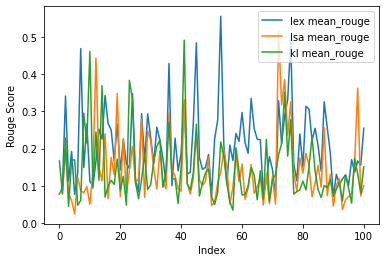

In [97]:
bible100 = sum_bible.loc[0:100].plot(y=['lex mean_rouge', 'lsa mean_rouge', 'kl mean_rouge'], use_index=True)
bible100.set(xlabel='Index', ylabel='Rouge Score')
bible100 = bible100.get_figure()

In [98]:
bible100.savefig('bible_100.pdf')

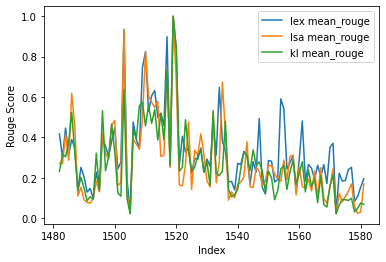

In [93]:
mormon100 = sum_mormon.iloc[-100:].plot(y=['lex mean_rouge', 'lsa mean_rouge', 'kl mean_rouge'], use_index=True) # last 100
mormon100.set(xlabel='Index', ylabel='Rouge Score')
mormon100 = mormon100.get_figure()

In [94]:
mormon100.savefig('mormon_last_100.pdf')

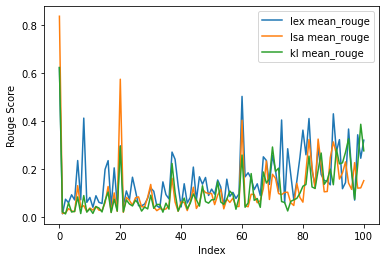

In [99]:
quran100 = sum_quran.loc[0:100].plot(y=['lex mean_rouge', 'lsa mean_rouge', 'kl mean_rouge'], use_index=True)
quran100.set(xlabel='Index', ylabel='Rouge Score')
quran100 = quran100.get_figure()

In [100]:
quran100.savefig('quran_100.pdf')